# CS6120
# Lab 3 - PyTorch Intro & Recurrent Neural Networks
A subset of the MATH60629A tutorial at the University of Toronto by *Oleksiy Ostapenko*

(Author's original sources: [Deep Learning Book](https://www.deeplearningbook.org/), [Christophe Olah's Blog](http://colah.github.io/), RNNs [tutorial](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q) by Yen-Ling Kuo and Eugenio Piasini)

In this practical session, we will explore how to model sequential data using recurrent neural networks (RNNs). In the first part, we will build an intuition on some moving parts of RNNs on a toy problem. The second part of the tutorial will showcase an example of applying RNNs to a more realistic dataset of textual data.

Here we will use [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1) library, which is a popular open-source library that provides many convenient tools for building artificial neural networks.

**Name - Nikita Vinod Mandal**

# Part 1: simple example (learning a sine wave)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(235)
np.random.seed(235)

%matplotlib inline
import matplotlib.pyplot as plt

Let's first generating some data!

In [27]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # targets are shifted by 1 step, since we're predicting the next step based on history

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

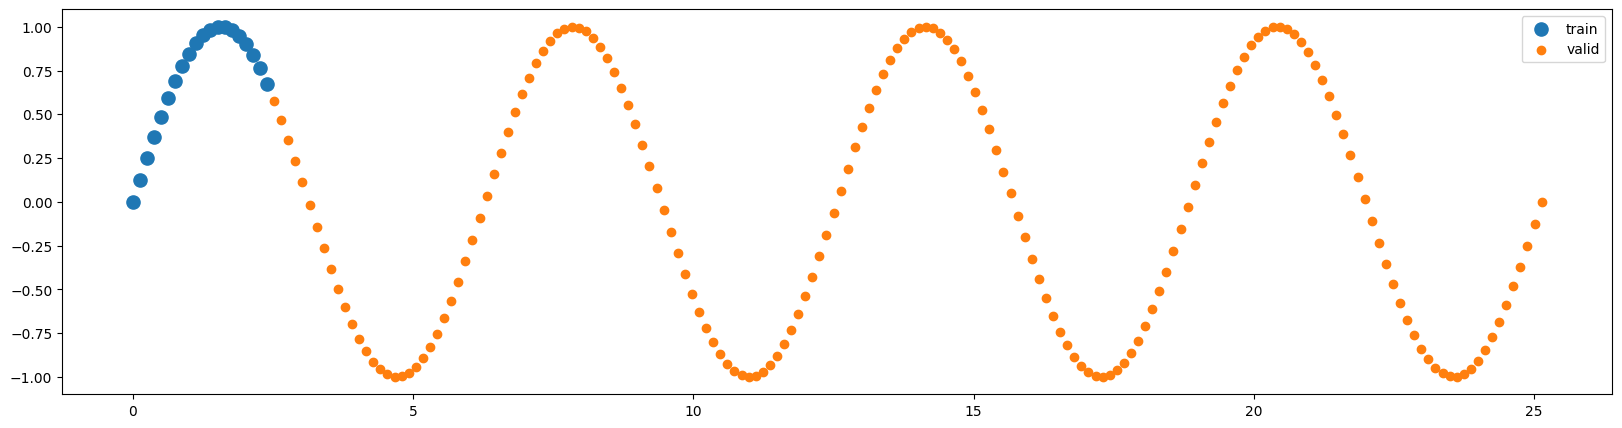

In [28]:
seq_length = 200 #total sequence length
portion_train =0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

We formulate the task as predicting the point at time step $t+1$ given the sequence of previous inputs up until time step $t$. We, therefore, need to shift our targets by one as mentioned in the class. Let's have a closer look at our input and target data again **(note: targets are shifted by 1)**.

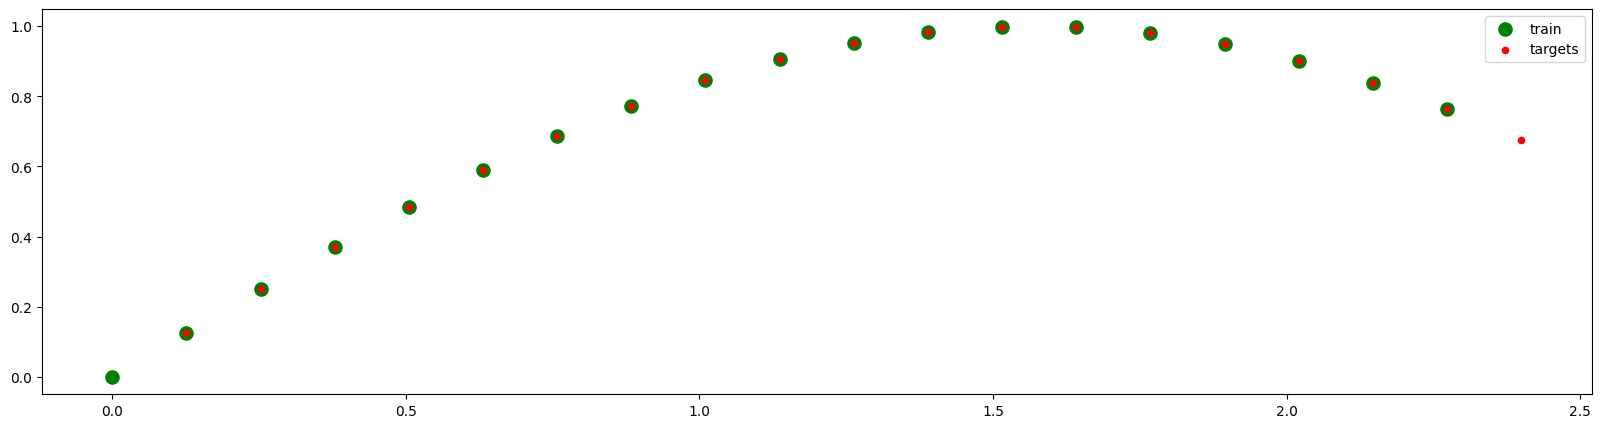

In [29]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

We will use data generated from a sine curve for our toy sequential prediction problem. Namely, given some part of the sequence as training data (blue points in the visualization above), our model will be tasked to generate the rest of the sequence (orange points).

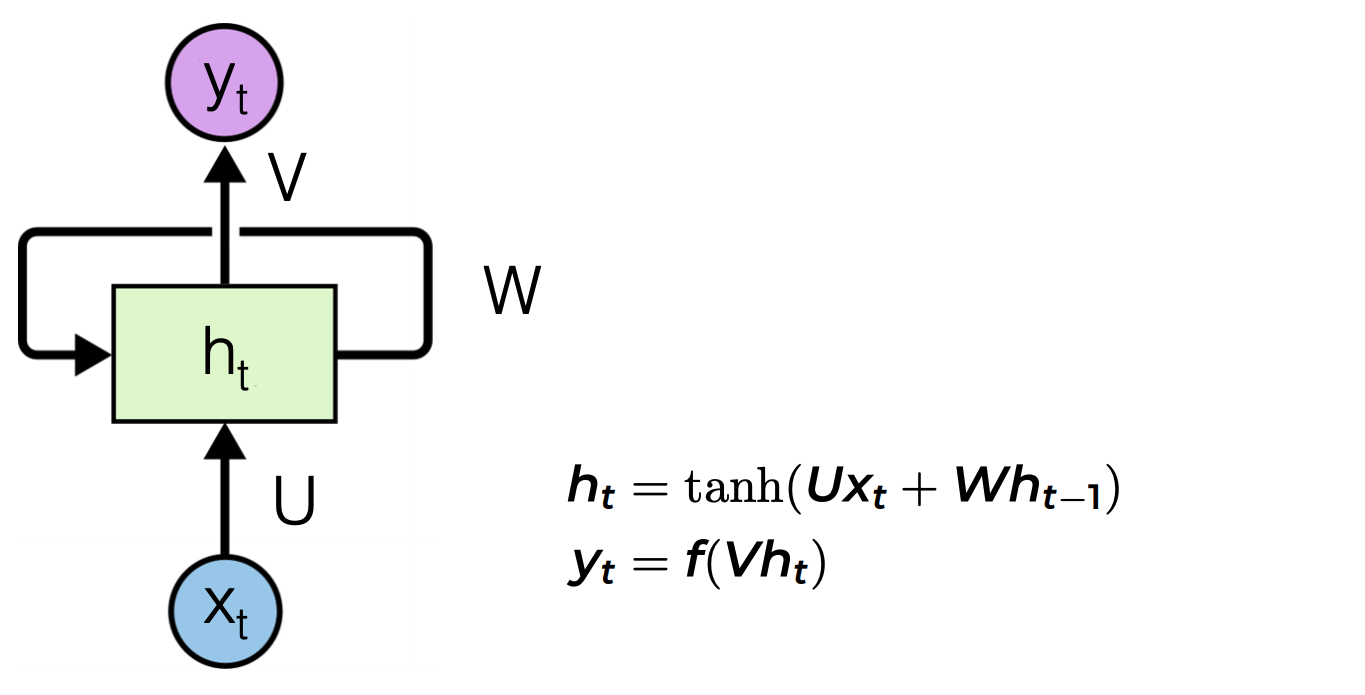
Image source http://colah.github.io/

As we have seen in the class, a simple recurrent network cell takes the current input at $X_t$ and produces an output ($y_t$) and a new hidden state that is passed through a recurrent connection to the next time step (in the figure above the recurrent connection uses weights W).

Let's first implement this simple RNN cell using Pytorch operations. Note, we use the $sigmoid$ activation (covered in the previous lab and lectures).

As you might recall from the previous lecture on feed-forward neural networks, the second equation in the figure above ($y_t = f(Vh_t)$) looks very similar to the feedforward layer. Indeed it is one, where $V$ denotes our learnable weights and $f$ is our activation function. Pytorch already provides us with an implementation of such a layer. We will add it outside of our simple RNN cell for convenience.


In [30]:
class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

    # Initialize weights to the correct shapes
        self.Wxh = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size))
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.zeros(hidden_size))


    def forward(self, x_t, state):
        h_prev = state

    # Ensure x_t has the correct size
        x_t = x_t.view(-1, self.input_size) 

    # Concatenate input and previous hidden state
        combined_input = torch.cat([x_t, h_prev], dim=1)

    # Adjusted matrix multiplication
    # You need to ensure self.Wxh has a shape of [hidden_size, input_size + hidden_size]
        h_t = torch.tanh(torch.mm(combined_input, self.Wxh.T) + self.bh)

        return h_t


Now, having implemented our simple recurrent cell, we need to put cells together to form a network.

Remember the principle of RNNs? The same(!) cell is used repeatedly receiving the new $X_t$ and the previous hidden state as input.

 We will also add our missing feed-forward layer (equation $y_t = f(Vh_t)$) here (we will set $f$ to identity, since we do not need any additional activation function here).

In [31]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define RNN cell
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)

    def init_hidden(self, batch_size=1):
        # Initialize the hidden state with zeros
        return torch.zeros(batch_size, self.hidden_size)

    def forward(self, X, h=None):
        if h is None:
            h = self.init_hidden(X.size(0))

        outputs = []

        for t in range(X.size(1)):
            x_t = X[:, t, :].view(-1, X.size(2))  # Extract the input at time step t
            h = self.rnn_cell(x_t, h)  # Update the hidden state
            outputs.append(h.view(1, -1, self.hidden_size))  # Store the hidden state

        return torch.stack(outputs), h

**Question 1 (RNNs)** : in the standard feed-forward neural network, all the training and test samples are considered independently. Can you explain how this can be a bad fit for sequential data modeling like the stock market or sequential sine curve fitting?

__Answer: As for a trader, historical data is a major deciding factor for making a prediction, also a machine learning model should model this dependency. This is explicitly modelled in our code in the line:
self.hx = self.rnn_cell.forward(X_t, self.hx) 
where we path the previous hidden state as input to the computation performed by the recurrent cell at the current time step__

**Question 2 (RNNs)**: given your answers to the previous question, can you explain in your own words, which role the hidden state ($h$) plays in RNNs?

__Answer: Each hidden states carries the information about the input sequence preceding the current time step. E.g. the sine curve example encodes the values of the preceding inputs, which can be essential for the prediction at the current time step (whether the next point in the sequence will be below or above the current one depends on the previous points).__


**Solution 1**
In a standard feed-forward neural network, each input sample is considered independently of the others. This independence assumption is not suitable for sequential data modeling, such as in the stock market or fitting a sequential sine curve, where the order of the data points is crucial. In time-series data, each observation is related to the previous ones, and there is temporal dependence. Ignoring this temporal structure can lead to the loss of important information and patterns present in the data.

For example:

1. In the stock market, the price at a given time is likely influenced by the historical prices and trends leading up to that point.
2. In sequential sine curve fitting, the value at a particular point in the sequence is influenced by the preceding values due to the periodic nature of the sine function.

Standard feed-forward networks lack the capability to capture and utilize temporal dependencies, making them less effective for tasks involving sequential data.


**Solution 2**
The hidden state (ℎ) in Recurrent Neural Networks (RNNs) plays a crucial role in capturing and remembering information from previous time steps. In the context of sequential data, the hidden state serves as a kind of memory that retains information about the input sequence encountered so far. The role of the hidden state can be summarized as follows:

1. Memory of Previous Information: The hidden state captures information from the input sequence up to the current time step. It retains knowledge about patterns, trends, or features observed in the past.

2. Temporal Dependency: The hidden state allows the network to consider the context of the current input in relation to the previous inputs. It enables the model to understand and learn from the sequential dependencies present in the data.

3. Feature Extraction: The hidden state acts as a feature vector that summarizes relevant information from the input sequence. It helps in transforming the input data into a representation that is suitable for the task at hand.

4. Learning Long-Term Dependencies: RNNs, with their hidden states, have the ability to capture long-term dependencies in sequential data, which is challenging for standard feed-forward networks.

Okay, we have implemented the 'forward path' of our RNN model. But what about the actual learning. The learning algorithm that is usually used to train RNNs is called [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time). Don't be afraid of the fancy name(!), the essential idea that underlines this and many other learning algorithms for the deep neural network is just repeatedly applying the chain rule of differentiation:

if $F = f(y), y = g(x)$, we have that $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (given f and g are differentiable functions).

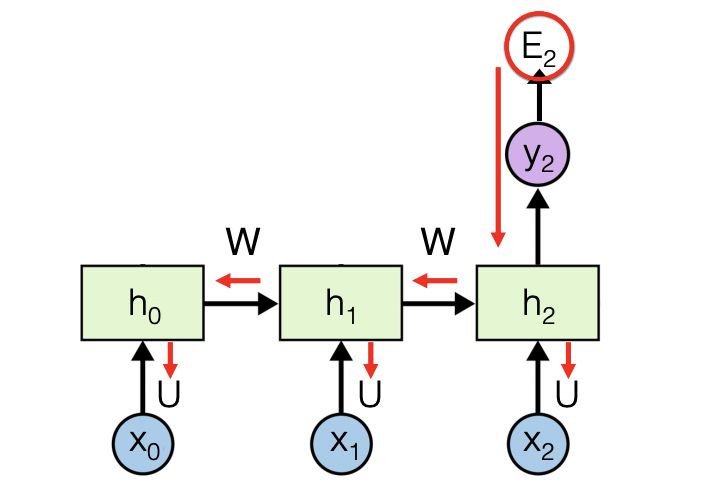
Image source http://colah.github.io/

The above image depicts a simple RNN with 3 states. Let's put it into mathematical equations ignoring the activation functions (and assuming our learnable weights are just scalars).

$h_o = U x_0$

$h_1 = U x_1 + W h_0$

$h_2 = U x_2 + W h_1$

Suppose we are dealing with a regression problem, let's include a simple L2 loss:

$E = \frac{1}{2} (h_2 - y)^2 $, where $y$ is the ground truth.

**Question 3 RNNs** : write down equations for the backpropagation through time for states $h_0$, $h_1$ and $h_2$ (hint: simply use the chain rule starting from the error term).

**Answer:

dE/dh2=h2−y 

dE/dh1=(h2−y)∗dh2/dh1=W(h2−y) 

dE/dh0=W(h2−y)∗dh1/dh0=(h2−y)W2**

To perform backpropagation through time (BPTT) for the given simple RNN with the provided equations, we'll apply the chain rule to calculate the gradients with respect to the error term $E. Let's compute the gradients for $h_0$, $h_1$ and $h_2$:

These equations provide the gradients needed for updating the learnable parameters \(U\) and \(W\) during the backpropagation process.

Don't worry, we are not going to code the backpropagation equations by hand this time, Pytorch will do the tedious work of differentiation for us.

Finally, let's now train our simple RNN on the input sequence generated previously.

In [32]:
hidden_size = 10
learning_rate = 0.01
# feel free to experiment with these

In [33]:
model = RNN(1,hidden_size) # first we instantiate our model

# set up model training below by looking up PyTorch documentation
# Run 300 epochs using the Adam optimizer

''' YOUR CODE HERE '''
import torch.optim as optim
import torch.nn.functional as F
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 300

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() 
    output, hidden = model(train_x)
    output = output.view(-1, model.hidden_size)[:, 0] 
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.step()
    
    # Optionally print the loss
    if epoch % 30 == 0:  # Print every 30 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.5026008486747742
Epoch 30, Loss: 0.09755554050207138
Epoch 60, Loss: 0.03631187602877617
Epoch 90, Loss: 0.02709110453724861
Epoch 120, Loss: 0.024159682914614677
Epoch 150, Loss: 0.022308610379695892
Epoch 180, Loss: 0.020670508965849876
Epoch 210, Loss: 0.019078340381383896
Epoch 240, Loss: 0.017520055174827576
Epoch 270, Loss: 0.01601700484752655


Let's see how our trained model can predict the training labels. Given a point from our training data (time $t$), we will ask our model to generate the next point ($t+1$), one point at a time. We will carry over the hidden state along the sequence generation.

Epoch 0, Loss: 0.7731416821479797
Epoch 30, Loss: 0.5675272941589355


C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([140, 1])) that is different to the input size (torch.Size([140, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60, Loss: 0.4033355712890625
Epoch 90, Loss: 0.29341748356819153
Epoch 120, Loss: 0.21619421243667603
Epoch 150, Loss: 0.1580011546611786
Epoch 180, Loss: 0.08655910193920135
Epoch 210, Loss: 0.04642990231513977
Epoch 240, Loss: 0.031281132251024246
Epoch 270, Loss: 0.024287577718496323


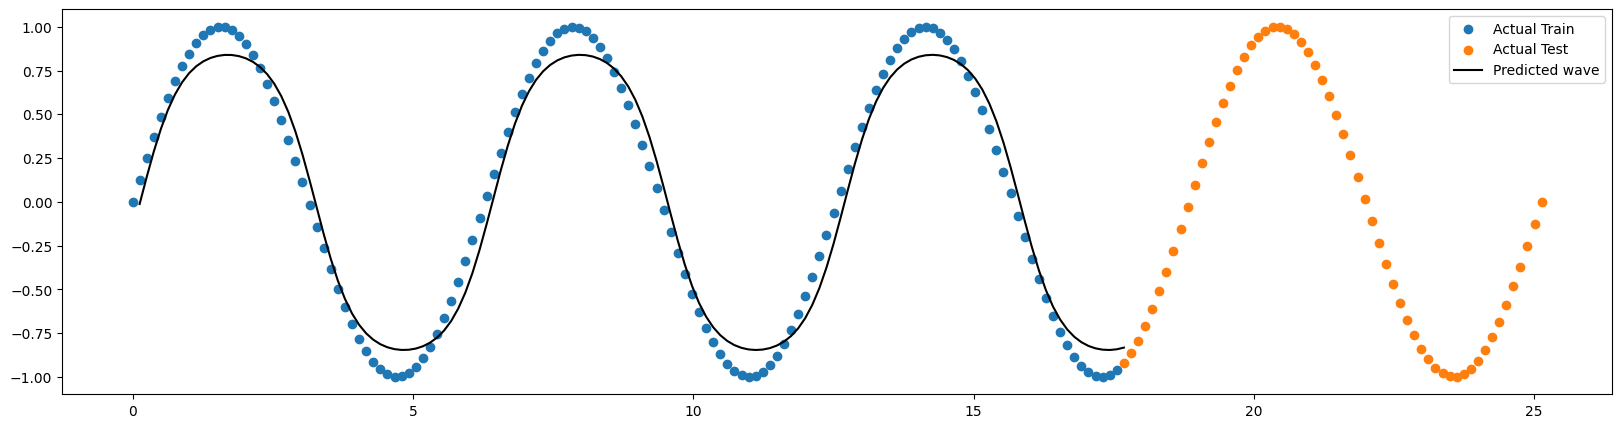

In [34]:
torch.manual_seed(235)
np.random.seed(235)

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8 * np.pi, train_len + valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len]
    ys = data[1:train_len + 1]  # Shifted by 1 for prediction

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys).view(-1, 1)
    return data, time_steps, train_x, train_y

class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wxh = nn.Parameter(torch.randn(input_size + hidden_size, hidden_size))
        self.bh = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        combined = torch.cat((x, h_prev), dim=1)
        h_next = torch.tanh(combined @ self.Wxh + self.bh)
        return h_next

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = RNN_Cell(input_size, hidden_size)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_size)
        output = []
        for i in range(x.size(1)):
            h = self.rnn_cell(x[:, i], h)
            output.append(h)
        output = torch.stack(output, dim=1)
        return output

def train_model(model, train_x, train_y, epochs=300, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_x)[:, -1]  # Get the last output for each sequence
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        if epoch % 30 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

def plot_results(time_steps, train_len, data, predictions):
    plt.figure(figsize=(20, 5))
    plt.scatter(time_steps[:train_len], data[:train_len], label='Actual Train')
    plt.scatter(time_steps[train_len:], data[train_len:], label='Actual Test')
    plt.plot(time_steps[1:train_len + 1], predictions, 'k', label='Predicted wave')
    plt.legend()
    plt.show()

# Parameters
seq_length = 200
portion_train = 0.7
train_len = int(seq_length * portion_train)
valid_len = seq_length - train_len

# Data Generation
data, time_steps, train_x, train_y = generate_sinus_wave(train_len, valid_len)

# Model
hidden_size = 10
model = RNN(1, hidden_size)

# Training
train_model(model, train_x, train_y, epochs=300, learning_rate=0.01)

# Predictions
model.eval()
with torch.no_grad():
    predictions = model(train_x)
    predictions = predictions[:, :, 0].view(-1).numpy()  # Adjust shape and convert to numpy

# Plotting
plot_results(time_steps, train_len, data, predictions)


As we can see in the plot above, that our model has learned to fit the training part of the sequence almost perfectly.

But what about the unseen part of the sequence?

In [35]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts


Let's generate the part of the sequence which was hidden from the model at training. Note, from the model's perspective, it is like generating completely new unseen data. If our data were e.g. text instead of a simple sine wave, we could ask our model to generate a completely new text, isn't that cool?

Note, to generate the unseen part of the sequence:
- we will first condition on the last point from the seen sequence, and ask the model to generate a new point
- then we will pass this newly generated point and the new hidden state as input to out model
- the model will then generate a new point conditioned on a point previously generated by the model
- In theory we could generate an infinitely long sequence on new data in this way.

As can be seen in the plot above, our model's performance is quite poor when it comes to generating the unseen part of the sequence (shown in green).

Looking at our training sequence (the orange part in the plot above), does it actually contain the information needed to be able to capture the periodic nature of the sine wave? Well, even as a human, if you had never seen a sine wave before, you probably would not be able to learn what a sine wave is solely from observing half of the period length of a sine wave (you would probably think it's just a parabola).

**Question 4 (RNNs)**: try increasing the training sequence length ($portion\_train$) in the code snippet below. (Hint: set the training length such that it includes at least one complete cycle of the sine wave.)

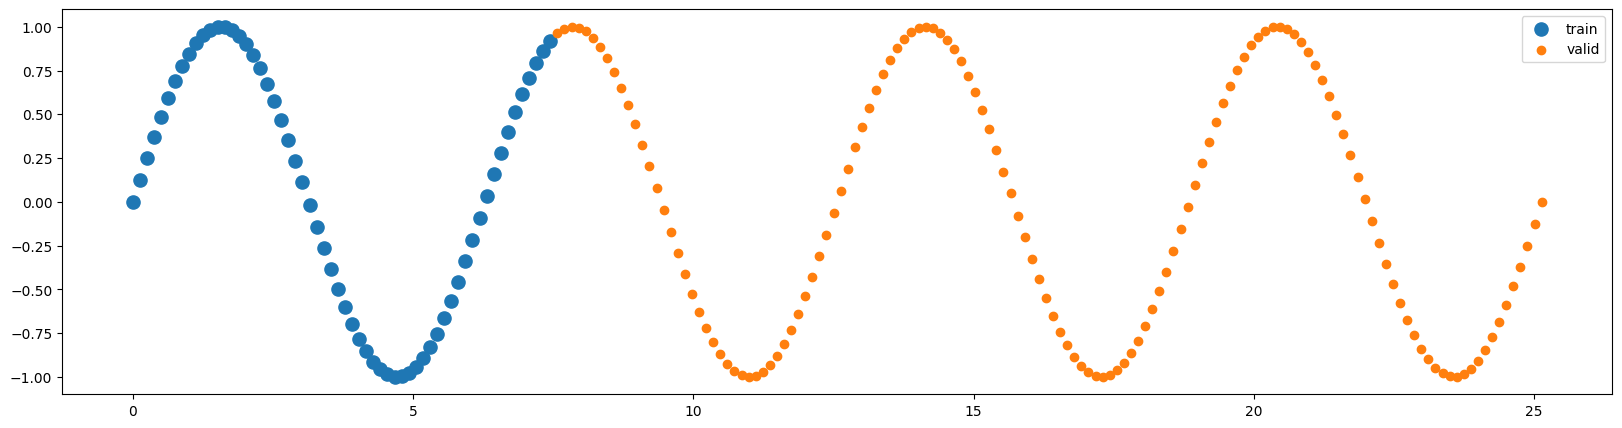

In [36]:

portion_train = 0.3 # change this parameter to try out a longer training sequence to cover at least one period

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

Let's train our model again, for a bit longer this time and see the result.

Epoch 0, Loss: 0.2997235655784607
Epoch 30, Loss: 0.22655078768730164
Epoch 60, Loss: 0.1710764616727829
Epoch 90, Loss: 0.14519846439361572
Epoch 120, Loss: 0.13096916675567627
Epoch 150, Loss: 0.09700533002614975
Epoch 180, Loss: 0.04648832231760025
Epoch 210, Loss: 0.026799391955137253
Epoch 240, Loss: 0.019803175702691078
Epoch 270, Loss: 0.016832105815410614


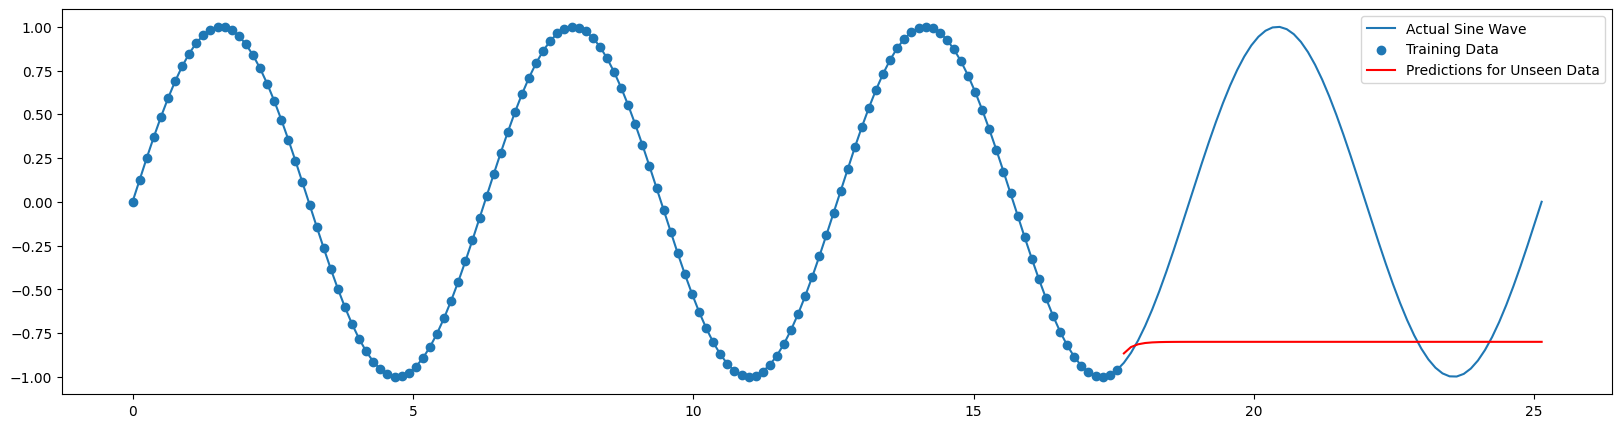

In [37]:
def generate_unseen_sequence(model, length, starting_point):
    model.eval()
    predictions = []
    input = starting_point.view(1, 1, -1)  # Adjust the view to match the expected input shape of the model
    with torch.no_grad():
        for _ in range(length):
            output = model(input)
            # Assuming the model outputs a vector and we're interested in the first value
            scalar_output = output[:, 0, 0].item()  # Adjust indexing to extract the first scalar value
            predictions.append(scalar_output)
            # Prepare the next input; if we're taking the first value, ensure it's reshaped correctly
            input = output[:, 0, 0].view(1, 1, 1)
    return predictions


# Parameters for generating the data
seq_length = 200
portion_train = 0.7
train_len = int(seq_length * portion_train)
valid_len = seq_length - train_len

# Generate the sine wave data
data, time_steps, train_x, train_y = generate_sinus_wave(train_len, valid_len)

# Initialize the RNN model
hidden_size = 10
model = RNN(1, hidden_size)

# Train the model
train_model(model, train_x, train_y)

# Predict the unseen part of the sequence
last_known_point = train_x[-1]  # Last known input from the training data
unseen_predictions = generate_unseen_sequence(model, valid_len, last_known_point)

# Plot the actual data, training data, and predictions
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(time_steps, data, label='Actual Sine Wave')
plt.scatter(time_steps[:train_len], data[:train_len], label='Training Data')
plt.plot(time_steps[train_len:], unseen_predictions, 'r', label='Predictions for Unseen Data')
ax.legend()
plt.show()


And voilà, our new model is somewhat better in capturing the periodic nature of the sine wave.

Note, if you rerun the training procedure for several times you will observe that each time you get a different result. This is due to the random reinitialization of the trainable weight in our RNN cell each time you restart training (re-instantiate the network object):

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


We certainly could try to get some better results by either:
- further hyperparameter tuning
- further increasing the length of the training sequence (MORE DATA is always good)

These are valid strategies often used in deep learning to improve the performance of the models. Yet, many times the real innovations come from improving the actual learning algorithms.